# Import the necessary libraries

In [1]:
from math import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colorbar as colorbar
from sphere6d import sphere6d
from plummer_sampler import plummer_model

# Create a model cluster
In this example we first create a model cluster that we will then fit.  To make this model cluster we have to 1) get a sample distribution of model stars and then 2) add velocities to those stars, which we do using the sphere6d code (which we can use to give us predicted mean velocities at any given point and we can add in random errors after the fact).

# Setting up cluster parameters
First what we want to do is to define the cluster's parameters.  It's RA, Dec, mean proper motion in the RA and Dec directions, the mean radial velocity (rv) of the cluster, it's distance (in parsec), it's tidal radius, and it's half light radius (hl_rad).

There are also a couple of parameters related to what rotation profile we want to use.  I typically use the Mackey et al. 2013 profile (currently you can use a mackey2013 or solid_body profile, but the macky2013 is probably better because it starts with no rotation in the center of the cluster which increases to a value of vmax at a radius of ramp and then starts to drop off).  

Finally there are a couple of parameters related to the shape and orientation of the clusters rotation.  The inclination and omega tell you about the orientation of the rotational axis.  Inclination = 0 the axis points up and as you increase the inclination it begins to point towards the viewer (90 means that the roation axis is aligned with the direction to the viewer) and then begins to point down.  Omega is defined so that it is like a position angle in the sky defined to increase from north through east.  Finally there is a velocity dispersion, that can be used with the ellipsoidal shape_func to give you rotational flattening.

In [2]:
cluster_ra = (13. + 26. / 60. + 47.28 / 3600.) * 15.
cluster_dec = -1 * (47. + 28. / 60. + 46.1 / 3600.)
cluster_pmra = 10  # in mas
cluster_pmdec = -10.  # in mas
cluster_rv = 100. # in km/s
cluster_dist = 5000 # in pc
cluster_tidal_rad_arcmin = 45.
cluster_tidal_rad = np.radians(cluster_tidal_rad_arcmin / 60.) * cluster_dist
cluster_hl_rad = np.radians(4.5 / 60.) * cluster_dist

pmra_sys = 10.
pmdec_sys = -10.
rv_sys = 100
vmax = 13.
ramp = 8.
inclination = np.radians(61.)
omega = np.radians(35.)
vsigma = 10.

# Getting the stellar distribution
Here we are sampling a Plummer distribution (which is a reasonable model for the density distribution for stars in a cluster) to give us a sample of model stars in a cluster.

In [3]:
plummer_mod = plummer_model(np.radians(4.5/60.)*5000., 10000)

# Set up the input dictionary
The way to set up the sphere6d object is to make an input dictionary of keywords (the "param" variables) and their values (the "values" variables).  The rot_curve, density_dist, and shape_func have a couple options, see the sphere6d code to see what kinds other inputs can be put in.

In [4]:
fixed_param = ['rot_curve', 'density_dist',
               'shape_func', 'rmax', 'ra', 'dec', 'dist']
fit_param = ['vel_disp', 'vmax', 'ramp', 'pmra_sys', 'pmdec_sys', 'rv_sys',
             'inclination', 'omega']
fixed_values = ['mackey2013', ['plummer_precomp', plummer_mod.rad, plummer_mod.phi, plummer_mod.theta], 
                'ellipsoidal', cluster_tidal_rad, cluster_ra, cluster_dec, cluster_dist]
# fixed_values = ['mackey2013', ['linear'], 'ellipsoidal', ocen_tidal_rad,
#                 ocen_ra, ocen_dec, ocen_dist]
fit_values = [vsigma, vmax, ramp, pmra_sys,
              pmdec_sys, rv_sys, inclination, omega]

In [5]:
dict_keys = fixed_param + fit_param
dict_values = fixed_values + fit_values

init_dict = {dict_keys[i]: dict_values[i] for i in range(len(dict_keys))}

# Make the cluster sphere6d object
Using the input parameters (and the model distribution of stars) defined above make our model cluster

In [6]:
cluster = sphere6d(init_dict)

# Set up a useful plotting function
This plot_model function will take the an input sphere6d object, and another that is a best fit model, and plot the requested form of motion (pmra, pmdec, or rv) showing the distribution of the input cluster color-coded by the motion selected.

In [7]:
def plot_model(cluster,model,motion):

    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(111)
    
    if motion == 'rv':
        
        H2, xedges, yedges = np.histogram2d(model.obs_ras,model.obs_decs,
                                            weights = model.obs_rvs-model.obs_rv_sys, bins=75)
        vmin = -15.
        vmax = 15.
        systemic = model.obs_rv_sys
        indiv = cluster.obs_rvs
        label = 'RV'

    if motion == 'pmra':
        
        H2, xedges, yedges = np.histogram2d(model.obs_ras,model.obs_decs,
                                            weights = model.obs_pmras-model.obs_pmra_sys, bins=75)
        vmin = -1.
        vmax = 1.
        systemic = model.obs_pmra_sys
        indiv = cluster.obs_pmras
        label = 'PM RA'



    if motion == 'pmdec':
        
        H2, xedges, yedges = np.histogram2d(model.obs_ras,model.obs_decs,
                                            weights = model.obs_pmdecs-model.obs_pmdec_sys, bins=75)
        vmin = -1.
        vmax = 1.
        systemic = model.obs_pmdec_sys
        indiv = cluster.obs_pmdecs
        label = 'PM Dec'


    Hcounts2, xedges, yedges = np.histogram2d(model.obs_ras,model.obs_decs,
                                              bins=[xedges,yedges])

    extent = [xedges[0],xedges[-1],yedges[0],yedges[-1]]

    H2 = H2/Hcounts2
    masked_H2=np.ma.masked_where(Hcounts2 < 1, H2)

    cset1 = ax.imshow(masked_H2.transpose((1,0)),extent=extent, cmap = plt.get_cmap('RdBu'),
                      origin='lower',interpolation='nearest', zorder=2, aspect='auto', vmin=vmin, vmax=vmax)

    cset2 = ax.scatter(cluster.obs_ras, cluster.obs_decs, c=indiv-systemic, s = 10, 
                           zorder = 3, cmap = plt.get_cmap('RdBu'), vmin=vmin, vmax=vmax)



    ax.tick_params(axis='both',direction='in',labelsize=15)

    ax.set_xlim([200.5,203])
    ax.set_ylim([-48.2,-46.8])

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar=fig.colorbar(cset1,cax=cax)
    cbar.ax.tick_params(labelsize=13)
    cbar.set_label(label,fontsize=18)
    ax.set_xlabel('RA',fontsize=18)
    ax.set_ylabel('Dec',fontsize=18)

    ax.invert_xaxis()

    plt.show()
    print(model.obs_pmra_sys,model.obs_pmdec_sys,model.obs_rv_sys,np.degrees(model.inclination),
         np.degrees(model.omega),model.vel_disp,model.vmax,model.ramp)

Now that we've made our mock cluster, we can plot it to see what it looks like.  This shows the radial velocity of stars relative to the systemic velocity of the cluster.

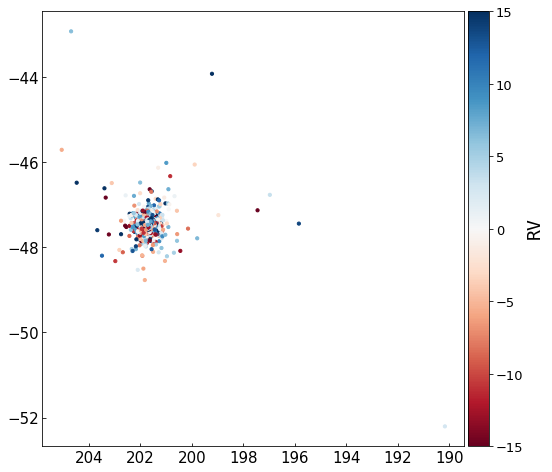

In [8]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111)

vmin = -15.
vmax = 15.

cset1 = ax.scatter(cluster.obs_ras, cluster.obs_decs, 
                   c=cluster.obs_rvs-cluster.obs_rv_sys+np.random.randn(
                       len(cluster.obs_rvs))*vsigma, s = 10, 
                   zorder = 3, cmap = plt.get_cmap('RdBu'), vmin=vmin, vmax=vmax)



ax.tick_params(axis='both',direction='in',labelsize=15)

# ax.set_xlim([200.5,203])
# ax.set_ylim([-48.2,-46.8])

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar=fig.colorbar(cset1,cax=cax)
cbar.ax.tick_params(labelsize=13)
cbar.set_label(r'$\mathtt{RV}$',fontsize=18)

ax.invert_xaxis()

plt.show()

So now we want to make our mock cluster a bit more realistic by adding random errors to our "observed" kinematics, and below that we are just orgainizing the "observable parameters" of our cluster stars, which sort of mimics the data that we would get from a real cluster

In [9]:
cluster.obs_rvs+=np.random.randn(len(cluster.obs_rvs))*vsigma
cluster.obs_pmras+=np.random.randn(len(cluster.obs_pmras))*vsigma/(4.74*cluster_dist)
cluster.obs_pmdecs+=np.random.randn(len(cluster.obs_pmdecs))*vsigma/(4.74*cluster_dist)

In [10]:
data_keys = ['data_ra','data_dec','data_rv','data_pmra','data_pmdec']
data_values = [cluster.obs_ras,cluster.obs_decs,cluster.obs_rvs,cluster.obs_pmras,cluster.obs_pmdecs]
data = {data_keys[i]: data_values[i] for i in range(len(data_keys))}

# Set up the cluster model
This looks very similar to what we did up above, because it is! We want to set up another sphere6d object, but this time it is our model that we are going to fit to the data.  Some of the parameters (like the RA, Dec, distance, tidal radius and half light radius) we want to keep the same (or if you are working with an observed cluster use literature values for these, they currently can't be fit, but that could be reworked in the future).

The parameters that we will fit, however, we don't need them to be super precise, so we set reasonable initial guesses for the input fit parameters, because we will fit them to get better numbers

In [11]:
# Basic input parameters - outside of the cluster pmra pmdec and rv these should all be defined for the model
cluster_ra = (13. + 26. / 60. + 47.28 / 3600.) * 15.
cluster_dec = -1 * (47. + 28. / 60. + 46.1 / 3600.)
cluster_pmra = 10  # in mas
cluster_pmdec = -10.  # in mas
cluster_rv = 100.
cluster_dist = 5000
cluster_tidal_rad_arcmin = 45.
cluster_tidal_rad = np.radians(cluster_tidal_rad_arcmin / 60.) * cluster_dist
cluster_hl_rad = np.radians(4.5 / 60.) * cluster_dist

# Fit parameters that will change, so we just need a reasonable initial guess 
# - note that currently vsigma is not fit, so a reasonably small number ~ 10 should be fine.
pmra_sys = 0.
pmdec_sys = 0.
rv_sys = 100
vmax = 10.
ramp = 10.
inclination = np.radians(0.)
omega = np.radians(0.)
vsigma = 10.

# Set up the input dictionaries of the parameters needed for the sphere6d initialization.  
# Here we use a linear density distribution because it is faster and should work reasonably well since we only care
# about the average cluster rotation at any point in the sky for the current iteration of the model.

fixed_param = ['rot_curve', 'density_dist',
               'shape_func', 'rmax', 'ra', 'dec', 'dist']
fit_param = ['vel_disp', 'vmax', 'ramp', 'pmra_sys', 'pmdec_sys', 'rv_sys',
             'inclination', 'omega']
fixed_values = ['mackey2013', ['linear'], 'ellipsoidal', cluster_tidal_rad,
                cluster_ra, cluster_dec, cluster_dist]
fit_values = [vsigma, vmax, ramp, pmra_sys,
              pmdec_sys, rv_sys, inclination, omega]

dict_keys = fixed_param + fit_param
dict_values = fixed_values + fit_values

init_dict = {dict_keys[i]: dict_values[i] for i in range(len(dict_keys))}

# Set up the cluster model using the input parameters

cluster_model = sphere6d(init_dict)

# Here we are using the cluster model and telling it to fit itself to the mock cluster data.
# xtol and ftol are parameters related to the fitting procedure, these are slightly higher tolerance than the defaults
# but our uncertainties are sufficiently large that we don't need as highly precise fit optimizations, and 
# using these values can speed up the fitting.

cluster_model.fit(**data, xtol=0.1, ftol=0.01)

/Users/chayes/research/sphere6d/sphere6d.py:448: RuntimeWarning: invalid value encountered in true_divide
  H = H / scaling


/Users/chayes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


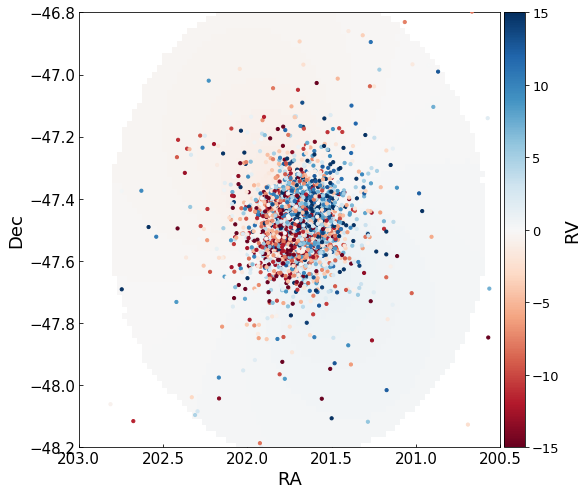

9.993131231444663 -10.002705012540874 99.98087546084241 97.98224186518378 -234.43895020298814 10.0 11.65437651104004 6.6598088406787515


In [12]:
# Use the plotting defined above to show our mock data points compared to the average RV field of the model
plot_model(cluster,cluster_model,'rv')

In [13]:
# Print out a comparison of the input and fit parameters 
# - note that there can be a degeneracy in the omega and inclination
cluster_inputs = [cluster.obs_pmra_sys,cluster.obs_pmdec_sys,cluster.obs_rv_sys,np.degrees(cluster.inclination), 
                  np.degrees(cluster.omega),cluster.vmax,cluster.ramp]

model_outputs = [cluster_model.obs_pmra_sys,cluster_model.obs_pmdec_sys,cluster_model.obs_rv_sys,
                 np.degrees(cluster_model.inclination), np.degrees(cluster_model.omega),
                 cluster_model.vmax,cluster_model.ramp]

labels = ['Systemic PM RA', 'Systemic PM Dec', 'Systemic RV', 'Inclination', 'Omega', 'Vmax', 'R amp']

for label, truth, fit in zip(labels,cluster_inputs,model_outputs):
    print('{}: Input = {:4.1f} / Fit = {:4.1f}'.format(label,truth,fit))

Systemic PM RA: Input = 10.0 / Fit = 10.0
Systemic PM Dec: Input = -10.0 / Fit = -10.0
Systemic RV: Input = 100.0 / Fit = 100.0
Inclination: Input = 61.0 / Fit = 98.0
Omega: Input = 35.0 / Fit = -234.4
Vmax: Input = 13.0 / Fit = 11.7
R amp: Input =  8.0 / Fit =  6.7
